In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import argparse
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
def load_pep_and_codify(file, max_len):
    aa_dict={'A':1,'R':2,'N':3,'D':4,'C':5,'Q':6,'E':7,'G':8,'H':9,'I':10,'L':11,'K':12,'M':13,'F':14,
        'P':15,'O':16,'S':17,'U':18,'T':19,'W':20,'Y':21,'V':22}
    with open(file, 'r') as inf:
        lines = inf.read().splitlines()
    pep_codes=[]
    long_pep_counter = 0
    newLines = []
    for pep in lines:
        if not len(pep) > max_len:
            current_pep=[]
            for aa in pep:
                current_pep.append(aa_dict[aa])
            pep_codes.append(current_pep)
            newLines.extend([pep])
        else:
            long_pep_counter += 1
    predict_data = keras.preprocessing.sequence.pad_sequences(pep_codes, value=0, padding='post', maxlen=max_len)
    return predict_data, long_pep_counter, newLines

In [3]:
file_path = 'compareModel/2019Bioinformatics_DeepMSPeptide/DeepMSPeptide/'
args = file_path + 'inputExample.txt'

print('Loading model...')
model_2_1D = keras.models.load_model(file_path + 'model_2_1D.h5')
print(model_2_1D.summary())

print('Loading input peptides')
predict_data, skipped, lines = load_pep_and_codify(args, 81)
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

print('Making predictions')
model_2_1D_pred = model_2_1D.predict(predict_data)
model_2_1D_pred = np.hstack((np.array(lines).reshape(len(lines), 1),model_2_1D_pred)).tolist()

Pred_output = []
for pred in model_2_1D_pred:
    if float(pred[1]) > 0.5:
        # pred.extend('0')
        Pred_output.append([pred[0], str(1-float(pred[1])), '0'])
    else:
        Pred_output.append([pred[0], str(1-float(pred[1])), '1'])
        # pred.extend('1')

outFile = '{0}_Predictions.txt'.format(args.split('.')[0])
print('Saving predictions to file {}'.format(outFile))
with open(outFile, 'w') as outf:
    outf.write('Peptide\tProb\tDetectability\n')
    outf.writelines('\t'.join(i) + '\n' for i in Pred_output)

Loading model...
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 81, 50)            1150      
_________________________________________________________________
dropout_2 (Dropout)          (None, 81, 50)            0         
_________________________________________________________________

# New Train

In [5]:
model = tf.keras.Sequential([
    # vacabulary size 23 (22 AminoAcid + zero padding)
    # embedding vector size 50
    # input length (including padding) 30 ( 81 to 30)
    tf.keras.layers.Embedding(23, 50, input_length=30),
    tf.keras.layers.Dropout(np.random.uniform(0, 0.2)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, padding='same'),
    tf.keras.layers.Conv1D(filters=64, kernel_size=2, strides=1),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dropout(np.random.uniform(0, 0.2)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 50)            1150      
_________________________________________________________________
dropout (Dropout)            (None, 30, 50)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 30, 128)           19328     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 29, 64)            16448     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

# 1. Make Data X_train, y_train, X_test, y_test

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

file_path = 'compareModel/2019Bioinformatics_DeepMSPeptide/DeepMSPeptide/'

In [7]:
# make DeepMSpeptide format
df_peptide_train = pd.read_csv('data/df_detect_peptide_train.csv')
df_peptide_test = pd.read_csv('data/df_detect_peptide_test.csv')

inp = open(file_path+'detect_peptide_train.txt', 'w')
inp_y = open(file_path+'detect_peptide_train_y.txt', 'w')
for x, y in df_peptide_train[['PEP', 'ID']].values:
    inp.write(x+'\n')
    inp_y.write(str(y)+'\n')
inp.close()
inp_y.close()

inp = open(file_path+'detect_peptide_test.txt', 'w')
inp_y = open(file_path+'detect_peptide_test_y.txt', 'w')
for x, y in df_peptide_test[['PEP', 'ID']].values:
    inp.write(x+'\n')
    inp_y.write(str(y)+'\n')
inp.close()
inp_y.close()

args = file_path + 'detect_peptide_train.txt'
print('Loading input peptides')
X_train, skipped, lines = load_pep_and_codify(args, 30)
tmp = open(file_path+'detect_peptide_train_y.txt')
y_train = np.array([int(_.replace('\n', '')) for _ in tmp.readlines()])
tmp.close()
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

args = file_path + 'detect_peptide_test.txt'
print('Loading input peptides')
X_test, skipped, lines = load_pep_and_codify(args, 30)
tmp = open(file_path+'detect_peptide_test_y.txt')
y_test = np.array([int(_.replace('\n', '')) for _ in tmp.readlines()])
tmp.close()
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

Loading input peptides
Succesfully loaded 269190 peptides and skipped 0
Loading input peptides
Succesfully loaded 67298 peptides and skipped 0
(215352, 30) (53838, 30) (67298, 30) (215352,) (53838,) (67298,)


# 2. train

In [4]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [8]:
history = model.fit(X_train, y_train, epochs=200, 
                    batch_size=100,
                    validation_data=(X_val, y_val),
                    callbacks=[es])

Train on 215352 samples, validate on 53838 samples
Epoch 1/200
215352/215352 [==============================] - 21s 99us/sample - loss: 0.7007 - acc: 0.4996 - val_loss: 0.6932 - val_acc: 0.5004
Epoch 2/200
215352/215352 [==============================] - 20s 95us/sample - loss: 0.6859 - acc: 0.5115 - val_loss: 0.6552 - val_acc: 0.6812
Epoch 3/200
215352/215352 [==============================] - 21s 96us/sample - loss: 0.6298 - acc: 0.7210 - val_loss: 0.6184 - val_acc: 0.7387
Epoch 4/200
215352/215352 [==============================] - 21s 95us/sample - loss: 0.6179 - acc: 0.7445 - val_loss: 0.6146 - val_acc: 0.7492
Epoch 5/200
215352/215352 [==============================] - 21s 95us/sample - loss: 0.6157 - acc: 0.7517 - val_loss: 0.6130 - val_acc: 0.7546
Epoch 6/200
215352/215352 [==============================] - 21s 96us/sample - loss: 0.6145 - acc: 0.7560 - val_loss: 0.6121 - val_acc: 0.7569
Epoch 7/200
215352/215352 [==============================] - 21s 95us/sample - loss: 0.6137

Epoch 114/200
215352/215352 [==============================] - 21s 96us/sample - loss: 0.6045 - acc: 0.7842 - val_loss: 0.6036 - val_acc: 0.7821
Epoch 115/200
215352/215352 [==============================] - 21s 96us/sample - loss: 0.6046 - acc: 0.7838 - val_loss: 0.6036 - val_acc: 0.7805
Epoch 116/200
215352/215352 [==============================] - 20s 95us/sample - loss: 0.6044 - acc: 0.7841 - val_loss: 0.6035 - val_acc: 0.7828
Epoch 117/200
215352/215352 [==============================] - 21s 96us/sample - loss: 0.6045 - acc: 0.7845 - val_loss: 0.6035 - val_acc: 0.7813
Epoch 118/200
215352/215352 [==============================] - 20s 95us/sample - loss: 0.6045 - acc: 0.7841 - val_loss: 0.6035 - val_acc: 0.7811
Epoch 119/200
215352/215352 [==============================] - 21s 97us/sample - loss: 0.6044 - acc: 0.7841 - val_loss: 0.6033 - val_acc: 0.7827
Epoch 120/200
215352/215352 [==============================] - 21s 96us/sample - loss: 0.6044 - acc: 0.7842 - val_loss: 0.6033 - v

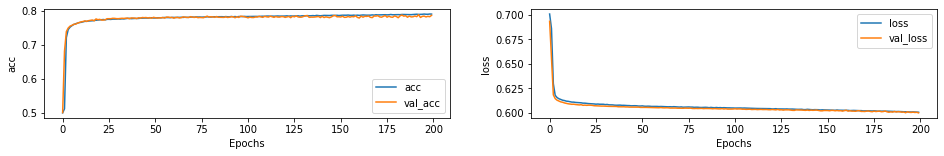

In [16]:
plt.figure(figsize=(16,2))
plt.subplot(1,2,1)
plot_graphs(history, 'acc')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

# 3. test

In [23]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import seaborn as sns

In [9]:
print('Making predictions')
model_pred = model.predict(X_test)
model_pred = np.hstack((np.array(lines).reshape(len(lines), 1),model_pred)).tolist()

Pred_output = []
for pred in model_pred:
    if float(pred[1]) > 0.5:
        Pred_output.append([pred[0], str(1-float(pred[1])), '0'])
    else:
        Pred_output.append([pred[0], str(1-float(pred[1])), '1'])

outFile = '{0}_Predictions.txt'.format(args.split('.')[0])
print('Saving predictions to file {}'.format(outFile))
with open(outFile, 'w') as outf:
    outf.write('Peptide\tProb\tDetectability\n')
    outf.writelines('\t'.join(i) + '\n' for i in Pred_output)

Making predictions
Saving predictions to file compareModel/2019Bioinformatics_DeepMSPeptide/DeepMSPeptide/detect_peptide_test_Predictions.txt


In [13]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

67298/67298 [==============================] - 4s 56us/sample - loss: 0.6021 - acc: 0.7825
Test Loss: 0.602053581072305
Test Accuracy: 0.7824898362159729


              precision    recall  f1-score   support

           0       0.75      0.86      0.80     33706
           1       0.83      0.71      0.76     33592

    accuracy                           0.78     67298
   macro avg       0.79      0.78      0.78     67298
weighted avg       0.79      0.78      0.78     67298

rf auc : 0.8618220779185728


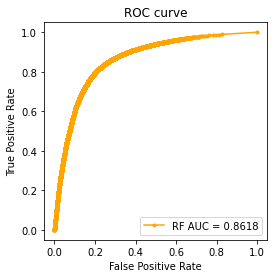

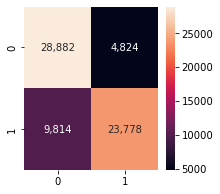

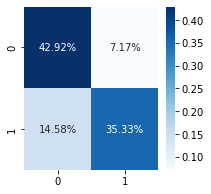

In [24]:
# prediction
y_pred = [1 if i>=0.5 else 0 for i in model.predict(X_test)]
print(classification_report(y_test, y_pred))
# AUC
probs = model.predict(X_test)
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

# max_length 81

In [25]:
args = file_path + 'detect_peptide_train.txt'
print('Loading input peptides')
X_train, skipped, lines = load_pep_and_codify(args, 81)
tmp = open(file_path+'detect_peptide_train_y.txt')
y_train = np.array([int(_.replace('\n', '')) for _ in tmp.readlines()])
tmp.close()
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

args = file_path + 'detect_peptide_test.txt'
print('Loading input peptides')
X_test, skipped, lines = load_pep_and_codify(args, 81)
tmp = open(file_path+'detect_peptide_test_y.txt')
y_test = np.array([int(_.replace('\n', '')) for _ in tmp.readlines()])
tmp.close()
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

Loading input peptides
Succesfully loaded 269190 peptides and skipped 0
Loading input peptides
Succesfully loaded 67298 peptides and skipped 0
(215352, 81) (53838, 81) (67298, 81) (215352,) (53838,) (67298,)


In [29]:
model81 = tf.keras.Sequential([
    tf.keras.layers.Embedding(23, 50, input_length=81),
    tf.keras.layers.Dropout(np.random.uniform(0, 0.2)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, padding='same'),
    tf.keras.layers.Conv1D(filters=64, kernel_size=2, strides=1),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dropout(np.random.uniform(0, 0.2)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model81.summary()
model81.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 81, 50)            1150      
_________________________________________________________________
dropout_6 (Dropout)          (None, 81, 50)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 81, 128)           19328     
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 80, 64)            16448     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)               

In [30]:
history = model81.fit(X_train, y_train, epochs=200, 
                    batch_size=100,
                    validation_data=(X_val, y_val),
                    callbacks=[es])

Train on 215352 samples, validate on 53838 samples
Epoch 1/200
215352/215352 [==============================] - 25s 115us/sample - loss: 0.6987 - acc: 0.4995 - val_loss: 0.6933 - val_acc: 0.5010
Epoch 2/200
215352/215352 [==============================] - 24s 112us/sample - loss: 0.6918 - acc: 0.4995 - val_loss: 0.6832 - val_acc: 0.5010
Epoch 3/200
215352/215352 [==============================] - 24s 112us/sample - loss: 0.6419 - acc: 0.6774 - val_loss: 0.6212 - val_acc: 0.7379
Epoch 4/200
215352/215352 [==============================] - 24s 111us/sample - loss: 0.6190 - acc: 0.7422 - val_loss: 0.6159 - val_acc: 0.7464
Epoch 5/200
215352/215352 [==============================] - 24s 111us/sample - loss: 0.6163 - acc: 0.7500 - val_loss: 0.6143 - val_acc: 0.7532
Epoch 6/200
215352/215352 [==============================] - 24s 111us/sample - loss: 0.6153 - acc: 0.7538 - val_loss: 0.6134 - val_acc: 0.7565
Epoch 7/200
215352/215352 [==============================] - 25s 114us/sample - loss:

215352/215352 [==============================] - 25s 118us/sample - loss: 0.6054 - acc: 0.7809 - val_loss: 0.6047 - val_acc: 0.7847
Epoch 114/200
215352/215352 [==============================] - 25s 118us/sample - loss: 0.6053 - acc: 0.7814 - val_loss: 0.6046 - val_acc: 0.7834
Epoch 115/200
215352/215352 [==============================] - 25s 115us/sample - loss: 0.6052 - acc: 0.7814 - val_loss: 0.6045 - val_acc: 0.7852
Epoch 116/200
215352/215352 [==============================] - 26s 119us/sample - loss: 0.6051 - acc: 0.7816 - val_loss: 0.6046 - val_acc: 0.7854
Epoch 117/200
215352/215352 [==============================] - 26s 119us/sample - loss: 0.6051 - acc: 0.7815 - val_loss: 0.6044 - val_acc: 0.7843
Epoch 118/200
215352/215352 [==============================] - 25s 117us/sample - loss: 0.6051 - acc: 0.7812 - val_loss: 0.6045 - val_acc: 0.7854
Epoch 119/200
215352/215352 [==============================] - 26s 119us/sample - loss: 0.6051 - acc: 0.7811 - val_loss: 0.6045 - val_acc:

67298/67298 [==============================] - 4s 67us/sample - loss: 0.6022 - acc: 0.7907
Test Loss: 0.6021953328052082
Test Accuracy: 0.7907218933105469
              precision    recall  f1-score   support

           0       0.77      0.83      0.80     33706
           1       0.82      0.75      0.78     33592

    accuracy                           0.79     67298
   macro avg       0.79      0.79      0.79     67298
weighted avg       0.79      0.79      0.79     67298

rf auc : 0.858128468918727


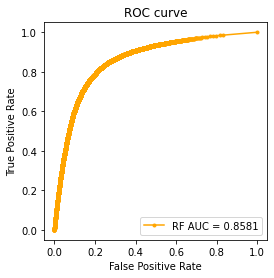

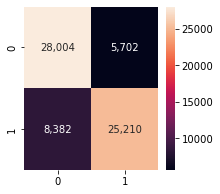

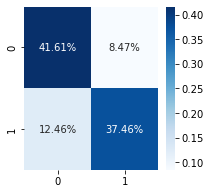

In [31]:
test_loss, test_acc = model81.evaluate(X_test, y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = [1 if i>=0.5 else 0 for i in model81.predict(X_test)]
print(classification_report(y_test, y_pred))
# AUC
probs = model81.predict(X_test)
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model81
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

# original param

In [36]:
_, test_acc, test_loss = model_2_1D.evaluate(X_test, y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

67298/67298 [==============================] - 5s 74us/sample - loss: 2.6481 - acc: 0.2395 - binary_crossentropy: 2.6481
Test Loss: 2.6481499671936035
Test Accuracy: 0.2395019233226776


              precision    recall  f1-score   support

           0       0.22      0.20      0.21     33706
           1       0.26      0.28      0.27     33592

    accuracy                           0.24     67298
   macro avg       0.24      0.24      0.24     67298
weighted avg       0.24      0.24      0.24     67298

rf auc : 0.1697024360705187


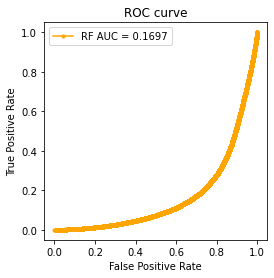

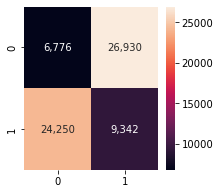

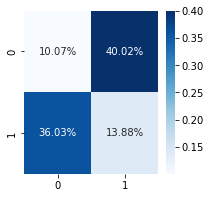

In [37]:
# prediction
y_pred = [1 if i>=0.5 else 0 for i in model_2_1D.predict(X_test)]
print(classification_report(y_test, y_pred))
# AUC
probs = model_2_1D.predict(X_test)
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model_2_1D
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()